# Random forest

In [1]:
# DB
import psycopg
import psycopg2

# Data
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from yellowbrick.model_selection import learning_curve

# Machine learning
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import validation_curve

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle
import joblib

## Data Engineering

### Exploration et validation

Compréhension du profilage des données pour obtenir des informations sur le contenu 
et la structure des données

- **Target** : calorie
- **ligne et colonne** : 15000 lignes et 9 colonnes
- **type de variable** : Numérique et catégorique (1)
- **valeur manquante** : Aucune

### Création d'une fonction pour se connecter a la DB via psycopg2

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "diet",
    "user"      : "clement",
    "password"  : "password"
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

### Fonction pour transformer la DB en Dataframe


In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [4]:
# Connect to the database
conn = connect(param_dic)
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

Connecting to the PostgreSQL database...
Connection successful


,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


### Exploration et validation

In [ ]:
df_db.info()

In [ ]:
df_db.hist(bins=50,figsize=(16,16))
plt.show()

In [ ]:
df_db.shape

In [ ]:
cor_df = df_db.corr() 
cor_df['calorie'].sort_values(ascending= False)

In [ ]:
# matrice des graphiques de nuage de points
%matplotlib inline

import seaborn as sns

cols = ["gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"] 

# montre le genre en différentes couleurs et un modèle de régression linéaire pour chacun d'eux
plot = sns.pairplot( df_db[cols], size=3, markers=".", hue="gender", kind="reg" )

# récupère les étiquettes x de la dernière ligne et les enregistre dans un tableauxlabels = []
for ax in plot.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append( xlabel )
    
# appliquer les étiquettes x du tableau au reste des graphes
y_ax_len = len(plot.axes[:,0])
for i in range(len( xlabels )):
    for j in range(y_ax_len):
        if j != i :
            plot.axes[j,i].xaxis.set_label_text( xlabels[ i ] )

## ITERATION 1 : une caractéristique - Duration 

### Entrainement du model et visualisation de la prédiction

On se focalise sur les calories et la durée de l'exercice pour cette première itération

Je sais à présent que je dois encoder le genre pour pouvoir lancer mon model

Une variable objectif (target) y à prédire --> calorie

Une ou plusieurs variables caractéristiques (features) x --> duration


In [5]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['duration']]
# y unidimensionnel
y = df_db['calorie']

In [6]:
# j'importe le model LinearRegression de la classe linear_model de sklearn

# Je sépare les données disponibles pour obtenir des données d'entrainement et des données de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
print(len(X_train))
print(len(X_test))

10050
4950


Evaluer un score par validation croisée.

La Cross-Validation est une méthode permettant de tester les performances d’un modèle prédictif de Machine Learning

Cette méthode est une procédure de ré-échantillonnage permettant d’évaluer un modèle même avec des données limitées.

On va faire 5 validation croisé avec le paramètre CV=5 et ensuite retourner la moyenne des métriques.

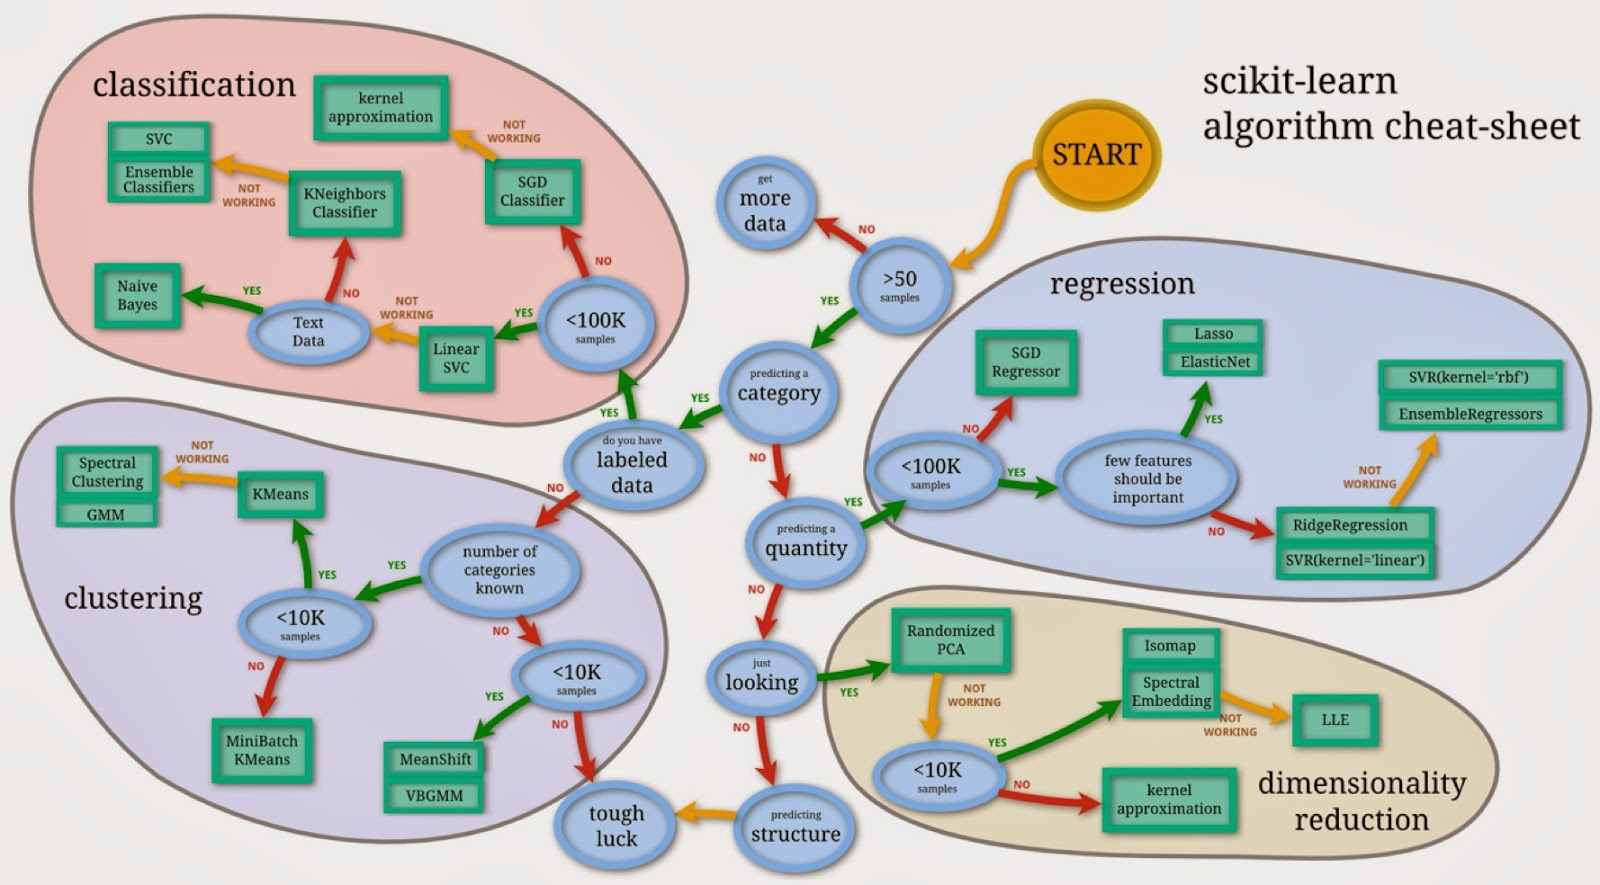

In [ ]:
# le r2 est proche de 1 donc trés bon dés le départ
# le R2 évalue la performance du model par rapport au niveau de variations présent dans les données
cross_val_score(LinearRegression(),X_train,y_train, cv=5).mean()

# LASSO

In [8]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)

In [9]:
lasso.fit(X_train,y_train)

Lasso(alpha=0.1)

In [7]:
# j'importe
# instancier le model
lr_1 = LinearRegression()

In [8]:
# l'objet lr_1 a un certain nombre de méthodes. L'un d'eux est la  fit() méthode
# qui est utilisée pour ajuster les données à un modèle linéaire
# et donc entrainement du modèl sur les données d'entrainement
lr_1.fit(X_train,y_train)

LinearRegression()

In [10]:
# Prediction sur de nouvelles valeurs (test)
lasso.score(X_test,y_test)

0.9127445023781473

In [11]:
yPrediction_lasso = lasso.predict(X_test)

In [9]:
# pour comprendre je peux utiliser la fonction help
help(lr_1.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : object
        Fitted Estimator.



In [ ]:
lr_1.coef_

In [10]:
# Prediction sur de nouvelles valeurs (test)
lr_1.score(X_test,y_test)

0.9127485305003332

notre model décrit 91% des variations du calories brulées par rapport a la duréee d'exercice

In [ ]:
# je fais ma prediction sur mon jeu de test
yPrediction = lr_1.predict(X_test)

In [ ]:
# visualisation de ma droite par rapport a mes points ()

import matplotlib.pyplot as plot

plot.scatter(X_train,y_train, color = 'red')
plot.plot(X_train, lr_1.predict(X_train), color = 'blue')
plot.title('Calorie vs Duration (Training set)')
plot.xlabel('Duration par tranche de 30 minutes')
plot.ylabel(' Nombre de calories brulées')
plot.show()

In [ ]:
import matplotlib.pyplot as plot

plot.scatter(X_test,y_test, color = 'red')
plot.plot(X_train, lr_1.predict(X_train), color = 'blue')
plot.title('Calorie vs Duration (Test set)')
plot.xlabel('Duration par tranche de 30 minutes')
plot.ylabel(' Nombre de calories brulées')
plot.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# a savoir la MSE pénalise bcp plus les grandes erreurs que la MAE

# MAE l'importanced'une erreur est linéaire avec son amplitude. si le dataset contient des **valeurs aberrantes**
print('MAE : ',mean_absolute_error(y_test, yPrediction))

# MSE si on accorde une grande importance aux garndes erreurs
print('RMSE : ',mean_squared_error(y_test, yPrediction))

print('Le coefficient de détermination ou R2 : ',r2_score(y_test, yPrediction))

# moins sensible au valeurs aberrantes
print('Mediane AE : Le model fais une erreur de prediction en moyenne de ',median_absolute_error(y_test, yPrediction), 'calories brulées ce qui est trés bien')

In [ ]:
# erreur absolu dans une variable pour l'afficher en histogramme
histogramme_erreur = np.abs(y_test, yPrediction)

In [ ]:
# bins : représente les intervalles
plt.hist(histogramme_erreur, bins=50)
plt.title('histogramme')
plt.xlabel('valeur des prediction')
plt.ylabel('Nombre de prediction')

# je vois que sur toutes les prédictions faites 200 ont une erreur proche de zero
# je vois que mes erreur suivent une loi de distribution expodentiel

In [ ]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
# j'utilisela bibliothèque yellowbrick dela classe modele selection pour utiliser le module learning curve

model_curve = LinearRegression()
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(model_curve, cv=cv, scoring='r2',train_sizes=sizes, n_jobs=5)


visualizer.fit(X_train,y_train)        # Fit the data to the visualizer
visualizer.show()

Le score d'entrainement(train) est bien supérieur au score de validation, le modèle nécessite probablement plus d'exemples de formation afin de généraliser plus efficacement.

Les courbes sont tracées avec les scores moyens, mais la variabilité pendant la validation croisée est indiquée avec les zones ombrées qui représentent un écart type au-dessus et au-dessous de la moyenne pour toutes les validations croisées.

Le modèle souffre d'une erreur due à la variance, il y aura alors plus de variabilité autour du score de validation croisée. C'est le cas ici présent

Cette courbe d'apprentissage montre une variabilité de test élevée et un score haut. Nous pouvons voir que les scores d'entrainement et de test n'ont pas encore convergé(presque a 9000 instance), donc potentiellement ce modèle bénéficierait de plus de données de d'entrainement. Enfin, ce modèle souffre principalement d'erreurs dues à la variance il est donc possible que le modèle soit surajusté.

## ITERATION 2 : Comparatif des modeles 

In [11]:
# utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['duration']]
# y unidimensionnel
y = df_db['calorie']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

In [16]:
ls = linear_model.Lasso(alpha=0.9)

In [17]:
ls.fit(X_train,y_train)

Lasso(alpha=0.9)

In [19]:
ls.score(X_test,y_test)

0.9132249873711892

In [20]:
pipelines = list()
pipelines.append(('LinearRegression', Pipeline([('LR', LinearRegression())])))
pipelines.append(('Lasso', Pipeline([('LS', linear_model.Lasso(alpha=0.9))])))
pipelines.append(('Ridge', Pipeline([('RDG', linear_model.Ridge(alpha=10))])))
#pipelines.append(('RidgeCV', Pipeline([('RDG_CV', linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)))])))

pipelines.append(('PolynomialLinearRegression', Pipeline([('PLR', PolynomialFeatures(degree=2)), ('linear', linear_model.LinearRegression(fit_intercept=False))])))
pipelines.append(('RandomForestRegressor', Pipeline([('RF', RandomForestRegressor(n_estimators=10, n_jobs=6, max_depth=20))])))
  
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

LinearRegression: 0.912601
Lasso: 0.912598
Ridge: 0.912601
PolynomialLinearRegression: 0.928792
RandomForestRegressor: 0.928561


In [ ]:

RF = RandomForestRegressor(n_estimators=10, n_jobs=6, max_depth=20)
RF.fit(X_train,y_train)

yPrediction2 = RF.predict(X_test)

In [ ]:
import matplotlib.pyplot as plot

plot.scatter(X_test,y_test, color = 'red')
plot.plot(X_test, yPrediction2, color = 'blue')
plot.title('Salary vs Experience (Test set)')
plot.xlabel('Years of Experience')
plot.ylabel('Salary')
plot.show()

## ITERATION 3 : plusieurs caractéristiques 

In [ ]:
# Je récupère toutes les feaabstures
X = df_db.drop(columns=['user_id','calorie'])
y = df_db['calorie']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

### Étiquetage des données 

In [ ]:
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])
X_test['gender'] = le.fit_transform(X_test['gender'])

In [ ]:
X_train['gender'].head(3)

In [ ]:
RF_model = RandomForestRegressor(n_estimators=10, n_jobs=6, max_depth=20)
RF_model.fit(X_train,y_train)
RF_model.score(X_test,y_test)

In [ ]:



# Calories prédit à partir de xtrain
ypred_train = RF_model.predict(X_train)

# créer la figure
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

# aplatir les axes pour faciliter leur indexation
axes = axes.flatten()

# itérer à travers les valeurs des colonnes, et utiliser i pour indexer les axes
for i, v in enumerate(X_train.columns):
    
    # sélectionner la colonne à tracer
    data = X_train[v]
    
    # Tracez les calories réel en fonction des caractéristiques
    axes[i].scatter(x=data, y=y_train, s=35, ec='white', label='actual')
    
    # Tracer les calories prédites en fonction des caractéristiques
    axes[i].scatter(x=data, y=ypred_train, c='pink', s=15, ec='white', alpha=0.5, label='predicted')

    # définir le titre et l'étiquette y
    axes[i].set(title=f'Feature: {v}', ylabel='calorie')

# definir une legende
axes[2].legend(title='Calories', bbox_to_anchor=(1.05, 1), loc='upper left')

# supprimez les axes inutilisés
for v in range(7, 16):
    fig.delaxes(axes[v])

## ITERATION 4 : RFE

<span style='color:red'> RFE (Recursive Feature Elimination)  </span>

**Utilisation de RFE : c'est une méthode de réduction de la dimensionnalité**

L'algorithme de RFE procède au classement des prédicteurs dans l'ordre d'importance en éliminant de manière récursive ceux qui ne sont pas importants, c'est-à-dire qui n'affectent pas la qualité du modèle.

Pour construire le modèle en utilisant RFE, je dois indiquer à RFE combien de caractéristiques je veux dans le modèle final. Il exécute alors un algorithme d'élimination des caractéristiques.

Notez que le nombre de caractéristiques à utiliser dans le modèle est un hyperparamètre.

In [ ]:
# Regardez les paramètres utilisés par mon random forest
print('Parametre utilisés:\n')
pprint(RF_model.get_params())

In [ ]:
max_depth = [4, 8, 12]

# Minimum samples for a split
min_samples_split = [2, 5, 10]

# Max features 
max_features = [4, 6, 8, 10]

In [ ]:
import random

# Fill in rfr using your variables
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=random.sample(max_depth, 1)[0],
    min_samples_split=random.sample(min_samples_split, 1)[0],
    max_features = random.sample(max_features, 1)[0]
)

# Print out the parameters
print(rfr.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Build a random search using param_dist, rfr, and scorer
random_search = RandomizedSearchCV(estimator=rfr,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   scoring=scorer
                                  )

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_features='auto')

param_dist = {
    'max_depth': [2, 4, 8, 12],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators':[10, 20, 30]
}

rs = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, 
                        cv=5, scoring=None, random_state=1111)

In [ ]:
rs.fit(X_train,y_train)

In [ ]:
params = rs.best_params_
params

# Random forest avec random search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
criterion = ['squared_error', 'absolute_error', 'poisson']

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
}
pprint(random_grid)

In [ ]:
# random grid pour trouver les meilleurs hyperparameters
# je créé le model
rf = RandomForestRegressor()
# 3 validation croisé
# recherche parmi 10 combinaisons différentes, et utilisation de tous les cœurs disponibles
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit le model  random 
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

In [ ]:
#model_lineaire.fit(X_train,y_train)
#model_lineaire.score(X_test,y_test)

In [ ]:
base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
#best_random = rf_random.best_estimator_
#random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
#print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# Random forest avec grid search

In [ ]:
param_grid = {'n_estimators': [100],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['auto'],
 'max_depth': [100],
 'bootstrap': [True],              
             }

In [ ]:
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.score(X_test,y_test)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test,y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

## chargement du model

In [ ]:
import pickle
# save the model to disk
filename = 'Random_forest_grid_search.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
with open('model_pkl', 'wb') as files:
    pickle.dump(grid_search, files)